In [1]:
from xbbg import blp
import utils
import pandas as pd 
import numpy as np
import os

import time
from tqdm import tqdm

In [ ]:
def update_fut_baskets(fut_type):

    fut_dic = utils.fut_dic
    fut_codes = utils.fut_codes
    fut_file= fut_dic[fut_type]

    fut_ticker =''.join([s.capitalize() for s in fut_file[:-1]])
    tickers_per_contract = fut_codes.apply(lambda x: fut_ticker + x + ' comdty')
    contracts = tickers_per_contract.index
    baskets = pd.DataFrame(columns =contracts, index=np.arange (70), dtype=str)
    baskets_filled = pd.read_csv(f'data/{fut_file}/baskets_{fut_file}.csv', index_col=0)

    for contract in baskets_filled.columns :
        baskets.loc[baskets_filled.index, contract] = baskets_filled.loc[:, contract].values 

    for contract, ticker in tickers_per_contract.iloc[-3:].items () :
        cusips = blp.bds (ticker,'FUT_DLVRBLE_BNDS_CUSIPS')
        if len(cusips)> 0:
            cusips = cusips['deliverable_bond_cusip_and_yellow_key']
            cusips_cut = [c[:-5] for c in cusips]
            baskets.loc[:len(cusips_cut)-1, contract] = np.array(cusips_cut)

    baskets = baskets. dropna(how='all')
    baskets = baskets.dropna(how='all', axis=1)

    output_dir = f'data/{fut_file}'
    if not os.path.isdir(output_dir):
        os.mkdir (output_dir)
    baskets.to_csv(f'data/{fut_file}/baskets_{fut_file}.csv')


def update_bonds():

    bonds= utils.get_bonds()

    fut_dic = utils.fut_dic

    all_cusips = bonds.index
    all_missing = []
    for fut_type in utils.fut_dic.keys():
        fut_file= fut_dic[fut_type]

        baskets = pd.read_csv(f'data/{fut_file}/baskets_{fut_file}.csv', index_col=0)
        cusips = np.unique(baskets.fillna('912810QC').values.flatten())
        missing = [c for c in cusips if c not in all_cusips] # type: ignore
        print(fut_type, len(missing))
        all_missing = all_missing + missing

    print('total: ' , len(all_missing))

    bonds_update = blp.bdp(
        [f'{cusip} Govt' for cusip in all_missing],
        ['id_isin', 'maturity','Int_acc_dt', "ISSUE_DT", "COUPON", "AMT_ISSUED" ]
    )

    bonds_update.index = bonds_update.index.to_series().apply(lambda x:x[:-5]) # type: ignore

    bonds_update.sort_values(by='issue_dt', inplace=True)
    bonds = pd.concat((bonds, bonds_update), axis=0)

    bonds['maturity'] = bonds['maturity'].apply(pd.to_datetime)
    bonds['int_acc_dt'] = bonds['int_acc_dt'].apply(pd.to_datetime)
    bonds['issue_dt'] = bonds['issue_dt'].apply(pd.to_datetime)
    
    output_dir = f'data/us_bonds'
    if not os.path.isdir(output_dir):
        os.mkdir (output_dir)
    bonds.to_csv('data/us_bonds/bonds_us_1980.csv')

In [ ]:
def load_fut_baskets(fut_type):
    
    fut_dic = utils.fut_dic
    fut_codes = utils.fut_codes
    fut_file= fut_dic[fut_type]

    fut_ticker =''.join([s.capitalize() for s in fut_file[:-1]])
    tickers_per_contract = fut_codes.apply(lambda x: fut_ticker + x + ' comdty')
    contracts = tickers_per_contract.index
    baskets = pd.DataFrame(columns =contracts, index=np.arange (70), dtype=str)
    baskets_filled = pd.read_csv(f'data/{fut_file}/baskets_{fut_file}.csv', index_col=0)

    for contract in baskets_filled.columns :
        baskets.loc[:, contract] = baskets_filled.loc[:, contract].values 


    for contract, ticker in tickers_per_contract.items () :
        cusips = blp.bds (ticker,'FUT_DLVRBLE_BNDS_CUSIPS')
        if len(cusips)> 0:
            cusips = cusips['deliverable_bond_cusip_and_yellow_key']
            cusips_cut = [c[:-5] for c in cusips]
            baskets[contract].iloc[:len(cusips_cut)] = cusips_cut

    baskets = baskets. dropna(how='all')
    baskets = baskets.dropna(how='all', axis=1)

    output_dir = f'data/{fut_file}'
    if not os.path.isdir(output_dir):
        os.mkdir (output_dir)
    baskets.to_csv(f'data/{fut_file}/baskets_{fut_file}.csv')


def load_bonds ():

    fut_dic = utils.fut_dic

    all_cusips = []
    for fut_type in utils.fut_dic.keys():
        fut_file= fut_dic[fut_type]

        baskets = pd.read_csv(f'data/{fut_file}/baskets_{fut_file}.csv', index_col=0)
        cusips = np.unique(baskets.fillna('912810QC').values.flatten())
        missing = [c for c in cusips if c not in all_cusips] # type: ignore
        print(fut_type, len(missing))
        all_cusips = all_cusips + missing

    print('total: ' , len(all_cusips))

    bonds = blp.bdp(
        [f'{cusip} Govt' for cusip in all_cusips],
        ['id_isin', 'maturity','Int_acc_dt', "ISSUE_DT", "COUPON", "AMT_ISSUED" ]
    )

    bonds.index = bonds.index.to_series().apply(lambda x:x[:-5]) # type: ignore
    output_dir = f'data/us_bonds'
    if not os.path.isdir(output_dir):
        os.mkdir (output_dir)
    bonds.to_csv('data/us_bonds/bonds_us_1980.csv')

## load bonds chaarac

In [24]:
for fut_type in utils.fut_dic.keys():
    #load_fut_baskets(fut_type)
    update_fut_baskets(fut_type)

In [ ]:
#load_bonds()
update_bonds()

In [52]:
bonds = utils.get_bonds()

## prices

In [116]:
def add_columns_to_tab (path, tickers, flds, tickers_mapping) :

    df = pd.read_csv(path, index_col=0, parse_dates=True)
    tickers = [c for c in tickers if tickers_mapping.loc[c] not in df.columns]
    if len(tickers) == 0:
        return 0
    debut, end = df.index[0], df.index[-1]
    update = blp.bdh(tickers, flds=flds ,start_date=debut, end_date=end, Per='D', calendarCodeOverride='US')
    update.index = pd.to_datetime(update.index)
    update = update.droplevel(level=1, axis=1)
    update.columns = tickers_mapping.loc[update.columns]
    df = pd.concat((df , update), axis=1)
    df.to_csv(path)
    return 1

def update_bond_fld_tab (path, flds) : 

    df = pd.read_csv(path, index_col=0, parse_dates=True)
    cusips = list(df.columns)
    tickers = [c + ' Govt' for c in cusips]
    tickers_mapping = pd.Series(index=tickers, data=cusips)

    debut = df.index[-1]
    end = pd.Timestamp.today()
    data = blp.bdh(tickers, flds=flds ,start_date=debut, end_date=end, Per='D', calendarCodeOverride='US')

    update = data
    update.index = pd.to_datetime(update.index)
    update = update.droplevel(level=1, axis=1)
    update.columns = tickers_mapping.loc[update.columns]
    df = pd.concat((df , update.iloc[1:]), axis=0)
    df.to_csv(path)

    ## add missing bonds

    df = pd.read_csv(path, index_col=0, parse_dates=True)
    cusips = [c for c in bonds.index if c not in df.columns]
    tickers = [c + ' Govt' for c in cusips]
    tickers_mapping = pd.Series(index=tickers, data=cusips)

    debut = bonds.loc[cusips]['issue_dt'].min() - pd.DateOffset(months=1)
    end = df.index[-1]
    update = blp.bdh(tickers, flds=flds ,start_date=debut, end_date=end, Per='D', calendarCodeOverride='US')
    update.index = pd.to_datetime(update.index)
    update = update.droplevel(level=1, axis=1)
    update.columns = tickers_mapping.loc[update.columns]

    df = pd.concat((df , update), axis=1)
    df.to_csv(path)

### new tab 

In [ ]:
cusips = list(bonds.index)
tickers = [c + ' Govt' for c in cusips]
tickers_mapping = pd.Series(index=tickers, data=cusips)

In [55]:
ptype = 'mid'
path = f'data/us_bonds/bonds_{ptype}_price.csv'
flds = f'px_{ptype}'

In [ ]:
debut = pd.to_datetime('11/03/2003')
end = pd.Timestamp.today()
data = blp.bdh('912810FP Govt', flds=flds ,start_date=debut, end_date=end, Per='D', calendarCodeOverride='US')

data.index = pd.to_datetime(data.index)
data = data.droplevel(level=1, axis=1)
data.columns = tickers_mapping.loc[data.columns]
data.to_csv(path)

In [9]:
for i in tqdm(range(220, len(tickers))):
    j = add_columns_to_tab(path, tickers[i:i+1], flds, tickers_mapping)
    if j==1 :
        time.sleep(10)

100%|██████████| 889/889 [3:25:10<00:00, 13.85s/it]  


In [10]:
ptype = 'bid'


path = f'data/us_bonds/bonds_{ptype}_price.csv'
flds = f'px_{ptype}'

debut = pd.to_datetime('11/03/2003')
end = pd.Timestamp.today()
data = blp.bdh('912810FP Govt', flds=flds ,start_date=debut, end_date=end, Per='D', calendarCodeOverride='US')

data.index = pd.to_datetime(data.index)
data = data.droplevel(level=1, axis=1)
data.columns = tickers_mapping.loc[data.columns]
data.to_csv(path)


In [11]:
for i in tqdm(range(len(tickers))):
    add_columns_to_tab(path, tickers[i:i+1], flds, tickers_mapping)
    time.sleep(10)

100%|██████████| 1109/1109 [4:17:17<00:00, 13.92s/it] 


### update existing

In [ ]:
ptype = 'mid'
path = f'data/us_bonds/bonds_{ptype}_price.csv'
flds = f'px_{ptype}'

update_bond_fld_tab (path, flds) 

In [117]:
ptype = 'bid'
path = f'data/us_bonds/bonds_{ptype}_price.csv'
flds = f'px_{ptype}'

update_bond_fld_tab (path, flds) 

## bond payment_dates

In [120]:
pyd = pd.DataFrame(columns = ['payment_date'])

def correct_coupon_date(x):
    t1=pd.offsets.BusinessDay(1)
    if x.day>20:
        # get × to month end
        x = x -t1 + pd.offsets.MonthEnd()
        return utils.next_business_day(x)

    else :
        # get × to day 15
        x = x.replace(day=15)
        return utils.next_business_day(x)
    
bonds=utils.get_bonds()
cusips=[c for c in bonds.index if c not in pyd.index]
for cusip in tqdm(cusips) :
    payments=pd.date_range(bonds.loc[cusip,'int_acc_dt'], bonds.loc[cusip,'maturity']+pd.offsets.BDay(29), freq=pd.DateOffset (months=6), inclusive='right')
    payments=pd.DataFrame(index=[cusip for _ in range(len(payments))], data=payments,columns=['payment_date'])
    payments['payment_date']=payments['payment_date'].apply(correct_coupon_date)

    pyd=pd.concat( (pyd, payments)) 

pyd.to_csv('data/us_bonds/estimated_payment_dates.csv')

  0%|          | 0/1126 [00:00<?, ?it/s]

C:\Users\hacen\AppData\Local\Temp\ipykernel_7368\3145329502.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pyd=pd.concat( (pyd, payments))
100%|██████████| 1126/1126 [00:03<00:00, 288.10it/s]


## calcuate yields, Duration , Dirty

In [122]:
import utils
import pandas as pd 
import numpy as np
import os
from tqdm import tqdm

In [133]:
bonds = utils.get_bonds()
P = utils.get_bond_prices()
pyd = utils.get_bonds_pyd()

#Dirty = P.copy()*np.nan
#Y = P.copy()*np.nan
#D = P.copy()*np.nan
#G = P.copy()*np.nan
# missing_dates = P.index


Dirty = utils.get_bond_prices(ptype='dirty')
Y = utils.get_bond_yields()
D = utils.get_bond_duration()
G = utils.get_fld_bonds('gamma')

calculated_dates = Dirty.index

missing = [c for c in P.columns if c not in Dirty.columns] 

for c in missing:
    for tab in [Dirty, Y, D, G] :
        tab[c] = np.nan


missing_dates = [date for date in P.index if date not in Dirty.index] 

for date in missing_dates:
    for tab in [Dirty, Y, D, G] :
        tab.loc[date] = np.nan

In [135]:
for date in tqdm(missing_dates):

    set_date = utils.add_business_day(date)

    basket = bonds.loc[P.loc[date].dropna().index]
    basket = basket[(basket['maturity'] > set_date) ]

    cusips = basket.index
    clean_prices = P.loc[date, cusips]


    AI = basket.apply(lambda x : 
                    utils.calculate_accrued_interest(x.coupon, x.maturity, max(set_date, x.issue_dt)),
                    axis=1
    )

    dirty_prices = clean_prices + AI
    Dirty.loc[date, cusips] = dirty_prices


    for cusip in cusips:
        maturity = bonds.loc[cusip, 'maturity']
        coupon = bonds.loc[cusip, 'coupon']
        set_date_cusip = max(set_date , bonds. loc[cusip, 'issue_dt'])
        dirty = dirty_prices.loc[cusip]
        bond_yield = utils.calculate_bond_yield(dirty, coupon, maturity, set_date_cusip, is_dirty=True)
        Y.loc[date, cusip] = bond_yield
        if np.isnan(bond_yield) : 
            print(cusip, dirty, coupon, maturity, set_date_cusip)
        bond_duration = utils.calculate_duration(dirty, coupon, maturity, set_date_cusip, bond_yield, mod=False)
        D.loc[date, cusip] = bond_duration

        bond_gamma = utils.calculate_gamma(coupon, maturity, set_date_cusip, bond_yield)
        G.loc[date, cusip] = bond_gamma

100%|██████████| 79/79 [04:19<00:00,  3.28s/it]


In [ ]:
Y.to_csv(f'data/us_bonds/bonds_mid_yield.csv')
D.to_csv(f'data/us_bonds/durations_mid.csv')
Dirty.to_csv(f'data/us_bonds/bonds_dirty_price.csv')
G.to_csv(f'data/us_bonds/bonds_gamma.csv')

## repo

In [125]:
ticker = 'FEDL01 Index'
flds = 'px_last'
path = f'data/repo/repo_ffund.csv'
if not os.path.isdir(f'data/repo'):
    os.mkdir(f'data/repo')

debut = pd.to_datetime('01/03/2000')
end = pd.Timestamp.today()
df = blp.bdh(ticker, flds=flds ,start_date=debut, end_date=end, Per='D', calendarCodeOverride='US')
df.index = pd.to_datetime(df.index)
df = df.droplevel(level=1, axis=1)
df.columns = ['ffund']
df.to_csv(path)

## mbs

In [142]:
# pylint: disable-all
main_path = 'e:\\ehz'
import sys
import os
sys.path.append(main_path)
os.chdir(main_path)

from xbbg import blp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(rc = { 'figure.figsize': (15, 5) })


In [143]:
tba_symbol = 'G2SF'
tba_mtg_rate_ticker = 'NMCMFR30 Index'

path = f'data/mbs/{tba_symbol}'
if not os.path.isdir(path):
    os.mkdir(path)

In [ ]:
flds = 'px_last'


debut = pd.to_datetime('01/03/2000')
end = pd.Timestamp.today()
df = blp.bdh(ticker, flds=flds ,start_date=debut, end_date=end, Per='D', calendarCodeOverride='US')
df.index = pd.to_datetime(df.index)
df = df.droplevel(level=1, axis=1)
df.columns = ['mtg_rate']
df.to_csv(f'{path}//mtg_rate.csv')

### price

In [164]:
tickers = []
for i in np.arange(1, 12, 0.25):
    tickers.append(f'{tba_symbol} {i} N Mtge')
 
tickers_names = blp.bdp(tickers, ['name', 'issue_dt', 'px_mid']).dropna()


tickers_names['coupon'] = tickers_names['name'].apply(lambda x : float(x.split(' ')[1]))
tickers_names.sort_values(by = 'coupon', inplace=True)

tickers = tickers_names.index

In [165]:
tickers = list(tickers)

In [171]:
df = pd.read_csv(f'{path}/mbs.csv', index_col=0, parse_dates=True)
#df = pd.DataFrame()

In [31]:
debut = pd.to_datetime('01/01/2020')
end = pd.Timestamp.today() + pd.offsets.BDay(0, normalize=True)

#debut = df.index[0] 
#end = df.index[-1] 

In [148]:
data = []

In [149]:
i1 = -1
#tickers[i1]

debut = pd.to_datetime('01/01/2020')
end = pd.Timestamp.today() + pd.offsets.BDay(0, normalize=True)
debut, end

(Timestamp('2020-01-01 00:00:00'), Timestamp('2025-04-30 00:00:00'))

In [150]:
for i, ticker in enumerate(tickers): 
    if i<= i1 : 
        continue
    try : 
        print(ticker)
        col = blp.bdh(tickers=ticker,
                        flds='px_mid',
                        start_date=debut,
                        end_date=end,
                        Per='D',
                        calendarCodeOverride= 'US') 
        data.append(col)

    except ValueError :
        print (ticker, ' errored')

G2SF 1.5 N Mtge
G2SF 2.0 N Mtge
G2SF 2.5 N Mtge
G2SF 3.0 N Mtge
G2SF 3.5 N Mtge
G2SF 4.0 N Mtge
G2SF 4.5 N Mtge
G2SF 5.0 N Mtge
G2SF 5.5 N Mtge
G2SF 6.0 N Mtge
G2SF 6.5 N Mtge
G2SF 7.0 N Mtge
G2SF 7.5 N Mtge


In [82]:
update = pd.concat(data, axis=1)
update = update.droplevel(level=1,axis=1)
update.index=update.index.to_series().apply(pd.to_datetime)

<Axes: >

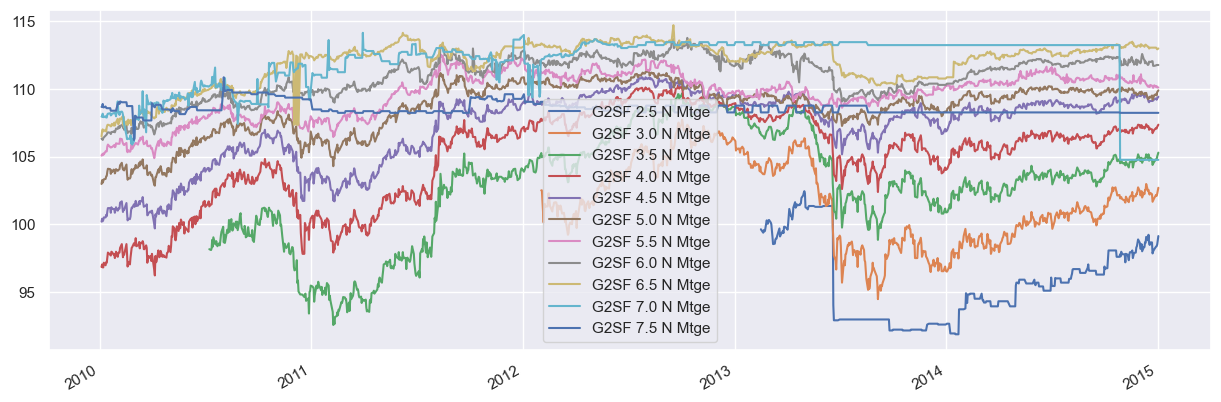

In [83]:
update.plot()

In [84]:
print(update.index[-1], df.index[0])

2015-01-02 00:00:00 2015-01-02 00:00:00


In [ ]:
df = pd.concat((update, df.iloc[1:]), axis=0)

In [63]:
df = update

<Axes: >

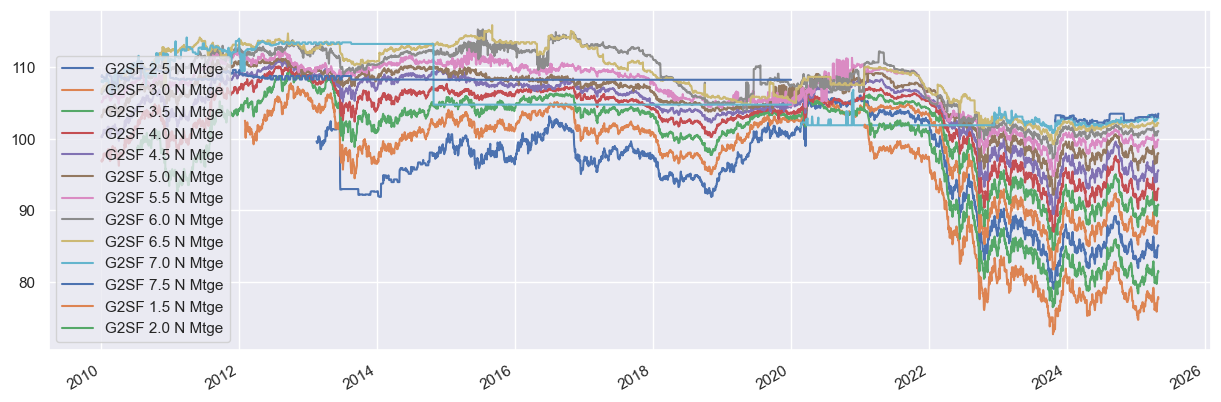

In [169]:
df.plot()

In [180]:
df[[c for c in tickers if c in df.columns]].to_csv(f'{path}/mbs.csv')

## oas

In [181]:
tickers_names['oas ticker'] = tickers_names['coupon'].apply(lambda x : str(x).replace('.', ''))
tickers_names['oas ticker'] = tickers_names['oas ticker'].apply(lambda x : f'{tba_symbol}0{x}S Index')
tickers_names['oas ticker']

G2SF 1.5 N Mtge    G2SF015S Index
G2SF 2.0 N Mtge    G2SF020S Index
G2SF 2.5 N Mtge    G2SF025S Index
G2SF 3.0 N Mtge    G2SF030S Index
G2SF 3.5 N Mtge    G2SF035S Index
G2SF 4.0 N Mtge    G2SF040S Index
G2SF 4.5 N Mtge    G2SF045S Index
G2SF 5.0 N Mtge    G2SF050S Index
G2SF 5.5 N Mtge    G2SF055S Index
G2SF 6.0 N Mtge    G2SF060S Index
G2SF 6.5 N Mtge    G2SF065S Index
G2SF 7.0 N Mtge    G2SF070S Index
G2SF 7.5 N Mtge    G2SF075S Index
Name: oas ticker, dtype: object

In [182]:
tickers = list(tickers_names['oas ticker'])

In [183]:
df = pd.read_csv(f'{path}/mbs_oas.csv', index_col=0, parse_dates=True)
#df = pd.DataFrame()

In [133]:
data = []

In [134]:
i1 = -1
#tickers[i1]

debut = pd.to_datetime('01/01/2010')
end = df.index[0]
#end = pd.Timestamp.today() + pd.offsets.BDay(0, normalize=True)
debut, end

(Timestamp('2010-01-01 00:00:00'), Timestamp('2015-01-02 00:00:00'))

In [135]:
for i, ticker in enumerate(tickers): 
    if i<= i1 : 
        continue
    try : 
        print(ticker)
        col = blp.bdh(tickers=ticker,
                        flds='px_last',
                        start_date=debut,
                        end_date=end,
                        Per='D',
                        calendarCodeOverride= 'US') 
        data.append(col)

    except ValueError :
        print (ticker, ' errored')

G2SF015S Index
G2SF020S Index
G2SF025S Index
G2SF030S Index
G2SF035S Index
G2SF040S Index
G2SF045S Index
G2SF050S Index
G2SF055S Index
G2SF060S Index
G2SF065S Index
G2SF070S Index
G2SF075S Index


In [136]:
update = pd.concat(data, axis=1)
update = update.droplevel(level=1,axis=1)
update.index=update.index.to_series().apply(pd.to_datetime)

<Axes: >

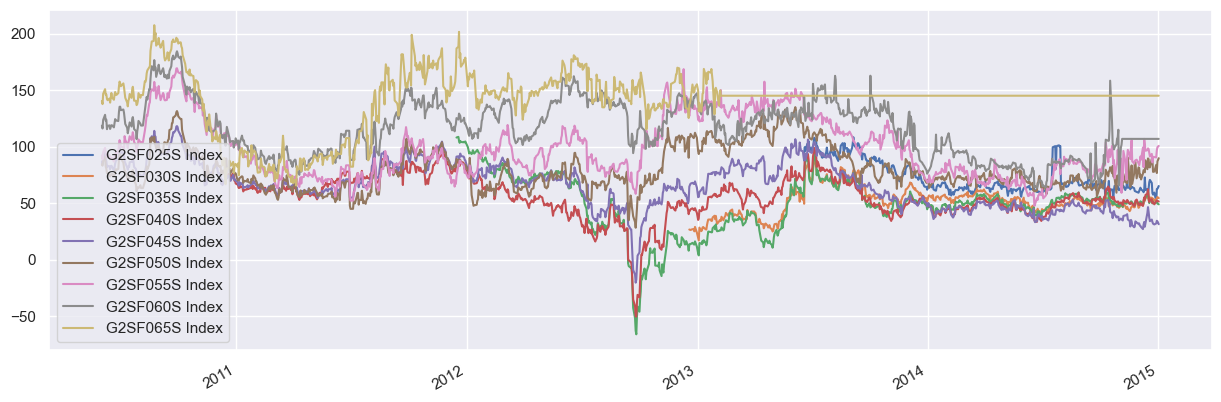

In [137]:
update.plot()

In [138]:
print(update.index[-1], df.index[0])

2015-01-02 00:00:00 2015-01-02 00:00:00


In [ ]:
df = pd.concat((update, df.iloc[1:]), axis=0)

In [117]:
df = update

<Axes: >

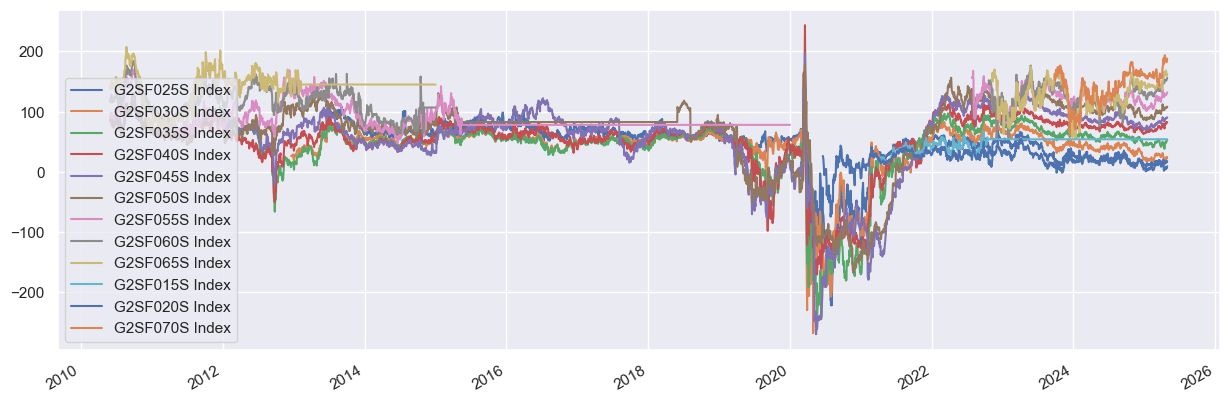

In [140]:
df.plot()

In [185]:
df[[c for c in tickers if c in df.columns]].to_csv(f'{path}/mbs_oas.csv')

## Vol


In [ ]:
vols = pd.read_clipboard(index_col=0)

In [ ]:
vols.columns = ['1M10Y', '3M10Y', '1M20Y', '3M20Y']

In [ ]:
update = pd.read_clipboard(index_col=0)

In [ ]:
update.columns = ['1M5Y', '3M5Y', '1M7Y', '3M7Y']

In [ ]:
os.mkdir('data/vol')
pd.concat((update, vols), axis=1).to_csv('data/vol/swaptions_vols.csv')

## swap rates 

### read clipboard from excel

In [ ]:
source = 'bloom'
df = pd.read_clipboard(index_col=0, parse_dates=True, dayfirst=True)
df['1D'] = df['1D'].shift(-1)
df = df.iloc[:-1]
df.to_csv(f'data/us_rates/{source}/rates.csv')

In [45]:
df.to_csv(f'data/us_rates/{source}/rates.csv')

## save discount prices

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton
from tqdm import tqdm
import utils
import swaplib as swlb

In [ ]:
source = 'bloom'
historical_swap_rates = utils.get_swap_rates(source)

max_ttm = 365*35
discount = pd.DataFrame(index = historical_swap_rates.index, columns =np.arange(365*35), dtype=np.float32)
discount_array = discount.values

source = 'bloom'
discount_prices_computed = pd.read_csv(f'data/us_rates/{source}/stripped_zc.csv', index_col=0, parse_dates= True)

In [ ]:
dates = historical_swap_rates.index
computed_dates = discount_prices_computed.index

len([d for d in dates if d not in computed_dates])

795

In [ ]:
start = 0
i = 0
for date in tqdm(dates):

    if i<start:
        i+=1
        continue

    if date in computed_dates : 
        discount_array[i] = discount_prices_computed.loc[date]
    else : 
        swap_rates_date = historical_swap_rates.loc[date]
        zc_prices = swlb.swap_rates_to_zc(date, swap_rates_date)
        zc_interpolated = swlb.interpolate_zc(date, zc_prices)[:max_ttm].astype(np.float32)
        discount_array[i] = zc_interpolated
    i+=1

100%|██████████| 4576/4576 [02:53<00:00, 26.37it/s]  


In [ ]:
discount.sort_index().to_csv(f'data/us_rates/{source}/stripped_zc.csv')

## save Z spread

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton
from tqdm import tqdm
import utils
import swaplib as swlb

In [8]:
source = 'bloom'
discount_prices = pd.read_csv(f'data/us_rates/{source}/stripped_zc.csv', index_col=0, parse_dates= True)

In [9]:
bonds = utils.get_bonds()
P = utils.get_bond_prices(ptype='dirty')
pyd = utils.get_bonds_pyd()

Z = utils.get_bonds_zspread()

In [10]:
dates = [d for d in P.index if d in discount_prices.index]
missing_dates = Z.index[Z.isna().all(axis=1)]

In [12]:
Z = Z.loc[dates]

In [ ]:
for date in tqdm(missing_dates):

    set_date = utils.add_business_day(date)

    basket = bonds.loc[P.loc[date].dropna().index]
    basket = basket[(basket['maturity'] > set_date) ]

    cusips = basket.index
    dirty_prices = P.loc[date, cusips]

    zc = discount_prices.loc[date]
    zc.index = pd.date_range(start=date, freq='D', periods=len(zc))

    C = pd. DataFrame (index = zc.index, columns = cusips, dtype = float)
    ZC = pd.DataFrame (index = zc.index, columns = cusips, dtype = float)
    discounted_mids = dirty_prices.copy()

    for cusip in cusips:
        coupon = bonds. loc [cusip, 'coupon']
        set_date_cusip = max(set_date , bonds. loc[cusip, 'issue_dt'])
        discounted_mids.loc[cusip] = zc.loc[set_date_cusip]*dirty_prices.loc[cusip]
        payment_dates = pyd. loc [cusip]
        payment_dates = payment_dates [payment_dates> set_date_cusip]

        if len (payment_dates)>0:
            cash_flows = np.zeros_like (payment_dates).astype(float)
            cash_flows = cash_flows + coupon/2
            cash_flows [-1] += 100
            C. loc[payment_dates, cusip] = cash_flows

        ZC [cusip] = zc

    C = C. dropna (how= 'all', axis=0)
    ZC = ZC.loc[C.index].copy()
    dt = (ZC. index - date). days/360
    h=1
    ## assuming zc = (1+r*h)**(-dt/h)
    spot_rates = (np.exp(np.log(ZC).multiply(-h/dt,axis=0))-1)/h

    def price(shift):
        zc_shift = np.exp(np.log(1+ (spot_rates+shift/10000)*h).multiply(-dt/h, axis=0))
        return ((zc_shift*C).sum() - discounted_mids).values

    shift = np.zeros_like(discounted_mids)
    root = newton (price, x0=shift)
    z_spread = pd.Series (index = cusips, data = root)
    Z.loc[date, cusips] = z_spread

100%|██████████| 351/351 [03:16<00:00,  1.79it/s]


In [14]:
Z.to_csv('data/us_bonds/bonds_z_spread_calc.csv')

## compute bond perfs

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import plotly.express as px
import utils

from tqdm import tqdm
import swaplib as swlb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 5)})

bonds = utils.get_bonds()
Dirty = utils.get_bond_prices(ptype='dirty')
pyd = utils.get_bonds_pyd()
repo = utils.get_repo('ffund')

In [2]:
def calculate_bond_perf(cusip, start_date, end_date, P= None, bonds=None, repo=None):
    if P is None : 
        P = utils.get_bond_prices(ptype='mid')
    if bonds is None :
        bonds = utils.get_bonds()

    if repo is None :
        repo = utils.get_repo('ffund')

    bond = bonds.loc[cusip]
    coupon = bond.coupon
    maturity = bond.maturity
    bond_price  = P[cusip].loc[start_date:end_date]
    perf = bond_price.iloc[1:]*np.nan
    issue_dt = bond.issue_dt
    dates = bond_price.index[:-1]

    for date in dates:
        
        buy_set_date = utils.add_business_day(date)  # type: ignore
        if buy_set_date < issue_dt:
            perf.loc[buy_set_date] = bond_price.loc[buy_set_date] - bond_price.loc[date]
        else:
            sell_date = buy_set_date
            sell_set_date = utils.add_business_day(sell_date)  # type: ignore
            clean_pnl = bond_price.loc[sell_date] - bond_price.loc[date]
            carry = utils.calculate_carry(
                    bond_price=bond_price.loc[date],
                    coupon=coupon,
                    maturity=maturity,
                    settlement_date=buy_set_date,
                    delivery_day=sell_set_date,
                    term_rp=repo.loc[date]  # Assuming 'repo' contains repo rates for the given date
            )
            perf.loc[sell_date] = clean_pnl + carry / 32
    
    return perf


def update_bonds_perf(last_date):
    print('Updating bond perf')
    bond_perf = utils.get_bond_perfs()
    
    if last_date is None:
        last_date = bond_perf.index[-2]
    else:
        last_date = min(last_date, bond_perf.index[-2])
    
    bond_perf = bond_perf.loc[:last_date]
    
    P = utils.get_bond_prices(ptype='mid')
    repo = utils.get_repo('fund')
    bonds = utils.get_bonds()
    
    for cusip in tqdm(P.columns):
        start_date, end_date = P[cusip].dropna().index[[0, -1]]
        start_date = max(start_date, last_date)
        if start_date >= end_date:
            continue
        
        perf = calculate_bond_perf(cusip, start_date, end_date, P=P, repo=repo, bonds=bonds)
        
        for date in perf.index:
            bond_perf.loc[date, perf.name] = perf.loc[date]
    
    bond_perf.to_csv('data/us_bonds/bonds_perf.csv')



In [3]:
P = utils.get_bond_prices(ptype='mid')
repo = utils.get_repo('ffund')
bonds = utils.get_bonds()
bond_perf = pd.DataFrame(columns = P.columns, index = P.index[1:], dtype=float)
for cusip in tqdm(P.columns):
    start_date, end_date = P[cusip].dropna().index[[0, -1]]
    perf = calculate_bond_perf(cusip, start_date, end_date, P=P, repo=repo, bonds=bonds)   
    bond_perf.loc[perf.index, cusip] = perf

bond_perf.to_csv('data/us_bonds/bonds_perf.csv')

100%|██████████| 1109/1109 [29:37<00:00,  1.60s/it] 


## compute ctd_tabs and otr_tabs

In [1]:
## filter.py

# pylint: disable=all
import os
import sys

import pandas as pd
import numpy as np
import plotly.express as px
import utils

from tqdm import tqdm
import swaplib as swlb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 5)})

bonds = utils.get_bonds()

P = utils.get_bond_prices(ptype='mid')
Dirty = utils.get_bond_prices(ptype='dirty')
Y = utils.get_bond_yields()
D = utils.get_bond_duration(ptype = 'mid')

roll_out_dates = utils.fut_codes.index.to_series().apply(
    lambda x: utils.add_business_day(pd.to_datetime(x), -4))
roll_out_dates.to_csv('data/us_bonds/roll_dates.csv')
roll_in_dates = roll_out_dates.shift(1)

zero_coupon_rates = utils.get_zc_rates(source='bloom')

In [6]:
for fut_type in utils.fut_dic:
    fut_file = utils.fut_dic[fut_type]

    first_contract = utils.start_dic[fut_type]
    contracts = utils.fut_codes.loc[first_contract:].index[:-1]
    dates = roll_in_dates.loc[contracts]
    contracts = list(contracts) + ['Jun 2025', 'Sep 2025', 'Dec 2025']

    CTDs = pd.DataFrame(index=contracts[:-3], columns=np.arange(4))
    for contract in tqdm(contracts[:-3]):

        date = roll_in_dates.loc[contract]
        set_day = utils.add_business_day(date)

        sub_contracts = contracts[contracts.index(contract):][:4]

        for contract_position, sub_contract in enumerate(sub_contracts):
            first_delivery = pd.to_datetime(sub_contract)
            try : 
                basket = utils.get_accurate_basket (bonds, sub_contract, fut_type)
            except : 
                y_lower, m_lower, y_upper, m_upper, y_i, m_i = utils.deliverable_rules[fut_type]
                basket = utils.get_basket(bonds, first_delivery, y_lower, m_lower, y_upper, m_upper, y_i, m_i)

            P_date = P.loc[date, basket.index].dropna()
            basket = basket.loc[P_date.index]

            if len(basket) == 0 : 
                CTDs.loc[contract, contract_position] = np.nan
                continue

            long = utils.tenors_dic[fut_type] > 6
            CF = utils.get_CF(basket.index, basket, first_delivery, long)
            dt = (first_delivery - date).days
            term_rp = ((zero_coupon_rates.loc[date, dt])**(-365/dt) - 1)*100
            PF_date = utils.P_to_PF(P_date, P_date.index, bonds, set_day, first_delivery, term_rp).dropna()
            PF_conv = (PF_date/CF).dropna()
            ctd = PF_conv.idxmin()
            CTDs.loc[contract, contract_position] = ctd

    CTDs.to_csv(f'data/filters/{fut_file}_ctd.csv')

100%|██████████| 61/61 [00:30<00:00,  2.01it/s]


In [40]:
n_otrs = 3
for tenor in [2,3,5,7,10,20,30]:
    basket = bonds.loc[P.columns]
    basket = basket[basket.length == tenor]
    basket = basket[basket.issue_dt > P.index[0]]
    #oldest = basket['issue_dt'].idxmin()
    #auction_dates = P[basket.index].apply(lambda x: x.dropna().index[0]) 
    #start = P[oldest].dropna().index[0]
    OTRs = pd.DataFrame(index=utils.calendar, columns=np.arange(n_otrs))

    basket.sort_values(by='issue_dt', inplace=True)
    for date in tqdm(OTRs.index):
        live_bonds = P.loc[date, basket.index].dropna()
        not_old = basket.loc[live_bonds.index, 'issue_dt'].apply(lambda x: (date-x).days <365)
        live_bonds = live_bonds[not_old]
        live_bonds = live_bonds.iloc[-n_otrs:]
        live_bonds = live_bonds.index.to_series()
        n = len(live_bonds)
        live_bonds.index = np.arange(n-1, -1, -1)
        OTRs.loc[date] = live_bonds

    OTRs.columns = [f'CT_{tenor}_{c}' for c in OTRs.columns]
    OTRs.to_csv(f'data/filters/{tenor}_otr.csv')

100%|██████████| 5290/5290 [00:08<00:00, 623.00it/s]
